In [2]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load embeddings
with open('../data/embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_emb = data['X_train_emb']
X_val_emb = data['X_val_emb']
X_test_emb = data['X_test_emb']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
label_encoder = data['label_encoder']

print(f"Loaded {len(X_train_emb)} train, {len(X_val_emb)} val, {len(X_test_emb)} test users")
print(f"Labels: {label_encoder.classes_.tolist()}")

Loaded 1790 train, 384 val, 384 test users
Labels: ['ADHD', 'OCD', 'aspergers', 'depression', 'ptsd']


In [4]:
def aggregate_timeline(timeline_embeddings, method='mean'):
    """
    Convert variable-length timeline into single fixed-size vector.
    
    Args:
        timeline_embeddings: numpy array of shape (num_posts, 384)
        method: 'mean' or 'max'
    
    Returns:
        numpy array of shape (384,)
    """
    if method == 'mean':
        return np.mean(timeline_embeddings, axis=0)
    elif method == 'max':
        return np.max(timeline_embeddings, axis=0)

# Aggregate all timelines
X_train_agg = np.array([aggregate_timeline(emb) for emb in X_train_emb])
X_val_agg = np.array([aggregate_timeline(emb) for emb in X_val_emb])
X_test_agg = np.array([aggregate_timeline(emb) for emb in X_test_emb])

print("Aggregated shapes:")
print(f"  X_train_agg: {X_train_agg.shape}")
print(f"  X_val_agg: {X_val_agg.shape}")
print(f"  X_test_agg: {X_test_agg.shape}")

Aggregated shapes:
  X_train_agg: (1790, 384)
  X_val_agg: (384, 384)
  X_test_agg: (384, 384)


In [5]:
# Train logistic regression
print("Training Logistic Regression baseline...")

baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

baseline_model.fit(X_train_agg, y_train)
print("✓ Model trained!")

# Predict on all sets
y_train_pred = baseline_model.predict(X_train_agg)
y_val_pred = baseline_model.predict(X_val_agg)
y_test_pred = baseline_model.predict(X_test_agg)

Training Logistic Regression baseline...
✓ Model trained!


In [6]:
print("=" * 60)
print("BASELINE MODEL RESULTS (Logistic Regression + Mean Pooling)")
print("=" * 60)

# Calculate metrics
results = {}
for split_name, y_true, y_pred in [
    ("Train", y_train, y_train_pred),
    ("Val", y_val, y_val_pred),
    ("Test", y_test, y_test_pred)
]:
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    results[split_name] = {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }
    
    print(f"\n{split_name} Set:")
    print(f"  Accuracy: {acc:.4f} ({acc*100:.1f}%)")
    print(f"  F1 (macro): {f1_macro:.4f}")
    print(f"  F1 (weighted): {f1_weighted:.4f}")

BASELINE MODEL RESULTS (Logistic Regression + Mean Pooling)

Train Set:
  Accuracy: 0.9531 (95.3%)
  F1 (macro): 0.9430
  F1 (weighted): 0.9537

Val Set:
  Accuracy: 0.9427 (94.3%)
  F1 (macro): 0.9308
  F1 (weighted): 0.9439

Test Set:
  Accuracy: 0.9297 (93.0%)
  F1 (macro): 0.9104
  F1 (weighted): 0.9325


In [7]:
print("\nDetailed Classification Report (Test Set):")
print("-" * 60)
print(classification_report(
    y_test, 
    y_test_pred, 
    target_names=label_encoder.classes_
))


Detailed Classification Report (Test Set):
------------------------------------------------------------
              precision    recall  f1-score   support

        ADHD       0.97      0.93      0.95        69
         OCD       1.00      0.94      0.97       144
   aspergers       0.94      0.92      0.93        85
  depression       0.68      1.00      0.81        32
        ptsd       0.91      0.89      0.90        54

    accuracy                           0.93       384
   macro avg       0.90      0.93      0.91       384
weighted avg       0.94      0.93      0.93       384



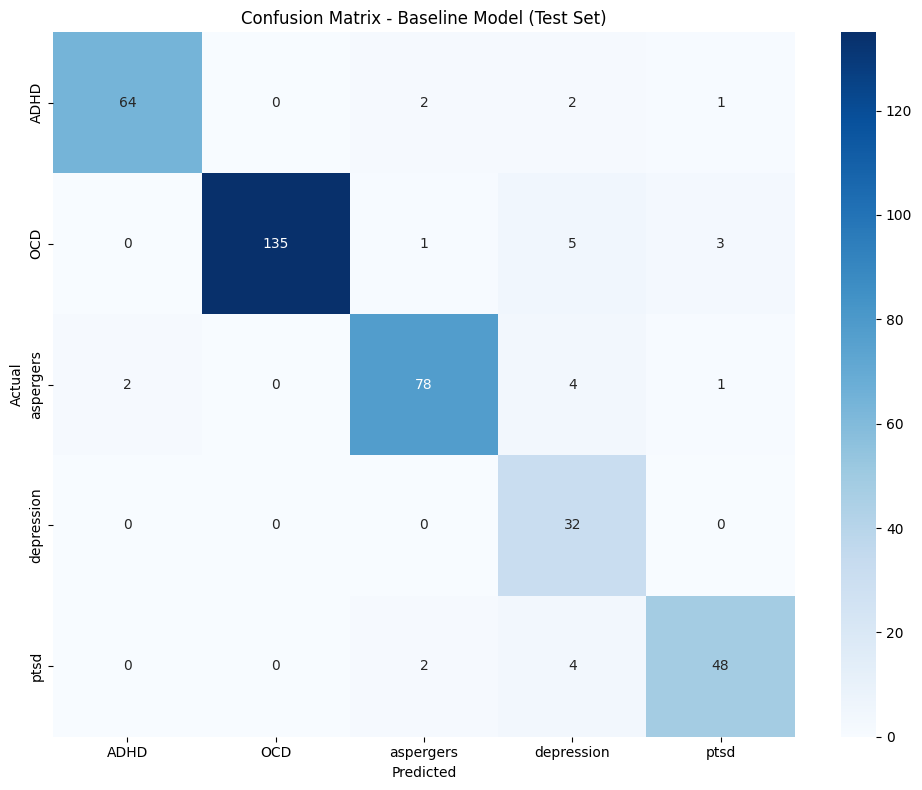

✓ Saved to results/baseline_confusion_matrix.png


In [8]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix - Baseline Model (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../results/baseline_confusion_matrix.png', dpi=150)
plt.show()

print("✓ Saved to results/baseline_confusion_matrix.png")

In [ ]:
# Save results 
baseline_results = {
    'model_name': 'Logistic Regression (Mean Pooling)',
    'results': results,
    'test_predictions': y_test_pred,
    'test_true': y_test
}

with open('../results/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("✓ Saved baseline results")
print()
print("BASELINE SUMMARY:")
print(f"  Test Accuracy: {results['Test']['accuracy']*100:.1f}%")
print(f"  Test F1 (macro): {results['Test']['f1_macro']:.4f}")
print()
print("This is what our sequential models need to BEAT!")

✓ Saved baseline results

BASELINE SUMMARY:
  Test Accuracy: 93.0%
  Test F1 (macro): 0.9104

This is what our sequential models need to BEAT!


In [ ]:
def evaluate_early_detection(X_emb, y_true, model, percentages=[0.25, 0.50, 0.75, 1.0]):
    """
    Evaluate model using only first X% of each user's timeline.
    
    Args:
        X_emb: List of timeline embeddings
        y_true: True labels
        model: Trained model
        percentages: List of history percentages to test
    
    Returns:
        Dictionary of results per percentage
    """
    results = {}
    
    for pct in percentages:
        # Truncate each timeline to first pct%
        X_truncated = []
        for timeline in X_emb:
            num_posts = max(1, int(len(timeline) * pct))  # At least 1 post
            truncated = timeline[:num_posts]
            X_truncated.append(truncated)
        
        # Aggregate truncated timelines
        X_agg = np.array([np.mean(t, axis=0) for t in X_truncated])
        
        # Predict
        y_pred = model.predict(X_agg)
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        
        results[pct] = {
            'accuracy': acc,
            'f1_macro': f1,
            'avg_posts_used': np.mean([len(t) for t in X_truncated])
        }
        
        print(f"{int(pct*100):3d}% history: Accuracy={acc:.4f}, F1={f1:.4f}, Avg posts={results[pct]['avg_posts_used']:.1f}")
    
    return results

print("Early Detection Results - BASELINE (Test Set)")
print("=" * 60)
baseline_early_results = evaluate_early_detection(X_test_emb, y_test, baseline_model)

Early Detection Results - BASELINE (Test Set)
 25% history: Accuracy=0.8411, F1=0.8147, Avg posts=2.0
 50% history: Accuracy=0.9245, F1=0.9070, Avg posts=4.4
 75% history: Accuracy=0.9167, F1=0.8970, Avg posts=6.5
100% history: Accuracy=0.9297, F1=0.9104, Avg posts=9.4


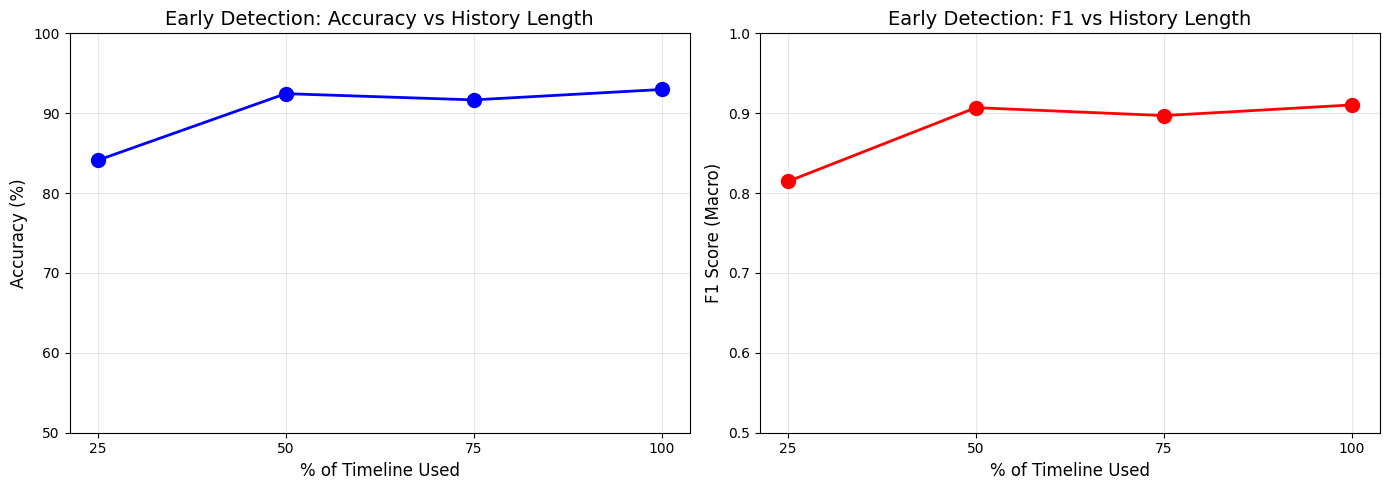

✓ Saved to results/baseline_early_detection.png


In [11]:
# Plot early detection curve
percentages = [0.25, 0.50, 0.75, 1.0]
accuracies = [baseline_early_results[p]['accuracy'] for p in percentages]
f1_scores = [baseline_early_results[p]['f1_macro'] for p in percentages]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot([p*100 for p in percentages], [a*100 for a in accuracies], 'bo-', linewidth=2, markersize=10)
axes[0].set_xlabel('% of Timeline Used', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Early Detection: Accuracy vs History Length', fontsize=14)
axes[0].set_xticks([25, 50, 75, 100])
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([50, 100])

# F1 plot
axes[1].plot([p*100 for p in percentages], f1_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('% of Timeline Used', fontsize=12)
axes[1].set_ylabel('F1 Score (Macro)', fontsize=12)
axes[1].set_title('Early Detection: F1 vs History Length', fontsize=14)
axes[1].set_xticks([25, 50, 75, 100])
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('../results/baseline_early_detection.png', dpi=150)
plt.show()

print("✓ Saved to results/baseline_early_detection.png")

In [12]:
# Update baseline results with early detection
baseline_results['early_detection'] = baseline_early_results

with open('../results/baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

print("✓ Updated baseline results saved")
print()
print("EARLY DETECTION SUMMARY (Baseline):")
print("-" * 40)
for pct in percentages:
    r = baseline_early_results[pct]
    print(f"  {int(pct*100):3d}% history: Acc={r['accuracy']*100:.1f}%, F1={r['f1_macro']:.3f}")

✓ Updated baseline results saved

EARLY DETECTION SUMMARY (Baseline):
----------------------------------------
   25% history: Acc=84.1%, F1=0.815
   50% history: Acc=92.4%, F1=0.907
   75% history: Acc=91.7%, F1=0.897
  100% history: Acc=93.0%, F1=0.910
